##**Determining the Salary of Newly Hired Employees Using ML**

##Loading the Data

Import Libraries

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LinearRegression, Ridge, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Set seaborn style for better visualizations
sns.set(style='whitegrid')

This cell imports all necessary libraries used throughout the notebook and sets the seaborn style for visualizations.

Loading the Main Dataset

In [8]:
# Function to load CSV data
def load_csv(filepath):
    try:
        data = pd.read_csv(filepath)
        print(f"Successfully loaded data from {filepath}")
        return data
    except FileNotFoundError:
        print(f"File not found: {filepath}")
    except pd.errors.EmptyDataError:
        print(f"No data: {filepath}")
    except pd.errors.ParserError:
        print(f"Error parsing data: {filepath}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Load the main dataset
ml_case_study_df = load_csv('/content/drive/MyDrive/ML case Study.csv')

Successfully loaded data from /content/drive/MyDrive/ML case Study.csv


This cell defines a function to load CSV data with error handling and uses it to load the main dataset.

In [33]:
# Display the first few rows of the main dataset
ml_case_study_df.head()

,College,City,Previous CTC,Previous job change,Graduation Marks,EXP (Month),CTC,Role_Manager
0,2,0,0.000683,3,0.411558,-1.421162,71406,1
1,2,0,0.234859,1,1.617149,-1.492061,68005,0
2,1,0,0.725756,2,-0.526124,-0.783065,76764,0
3,1,0,-0.978255,2,1.416217,-0.428566,82092,0
4,3,0,0.354803,4,0.947376,-0.499466,73878,0


In [9]:
# Display the last few rows of the main dataset
ml_case_study_df.tail()

,College,City,Role,Previous CTC,Previous job change,Graduation Marks,EXP (Month),CTC
1584,BITS Pilani (Goa Campus),Surat,Executive,61285.0,3,44,60,77283.59
1585,NIT Warangal,Rajpur Sonarpur,Executive,63140.0,1,44,24,68416.86
1586,NIT Tiruchipally (Trichy),Ahmedabad,Executive,44907.0,1,60,19,70186.19
1587,IIIT Hyderabad,Durgapur,Executive,52054.0,2,67,29,73394.09
1588,R.V. College of Engineering,Delhi,Manager,44353.0,3,75,18,70056.31


Loading Additional Data

In [10]:
# Load supplementary datasets
cities_df = load_csv('/content/drive/MyDrive/cities.csv')
colleges_df = load_csv('/content/drive/MyDrive/Colleges.csv')

Successfully loaded data from /content/drive/MyDrive/cities.csv
Successfully loaded data from /content/drive/MyDrive/Colleges.csv


In [11]:
# Display the first few rows of supplementary datasets
print("Cities DataFrame:")
print(cities_df.head())
print("\nColleges DataFrame:")
print(colleges_df.head())

Cities DataFrame:
  Metrio City non-metro cities
0      Mumbai         Dehradun
1       Delhi         Durgapur
2     Kolkata          Asansol
3     Chennai         Rourkela
4   Bangalore        Kozhikode

Colleges DataFrame:
          Tier 1          Tier 2                                      Tier 3
0     IIT Bombay  IIIT Bangalore  Ramaiah Institute of Technology, Bengaluru
1      IIT Delhi      IIIT Delhi                      TIET/Thapar University
2  IIT Kharagpur          IGDTUW                         Manipal Main Campus
3     IIT Madras     NIT Calicut                                 VIT Vellore
4     IIT Kanpur   IIITM Gwalior                             SRM Main Campus


##Data Transforming

Mapping Cities to Binary Values

In [12]:
# Create a dictionary to map cities to binary values
city_map = {row['Metrio City']: 1 for index, row in cities_df.iterrows()}
city_map.update({row['non-metro cities']: 0 for index, row in cities_df.iterrows()})

# Map the City column in the main dataset
ml_case_study_df['City'] = ml_case_study_df['City'].map(city_map)

# Check for unmapped cities
unmapped_cities = ml_case_study_df['City'].isnull().sum()
if unmapped_cities > 0:
    print(f"Warning: {unmapped_cities} cities were not mapped and have been set to NaN.")

This cell creates a dictionary to map cities to binary values and uses it to transform the City column in the main dataset. It also checks for unmapped cities.

 Mapping Colleges to Numerical Values

In [13]:
# Create a dictionary to map colleges to numerical values based on tiers
college_map = {}
for col in colleges_df.columns:
    tier = int(col.split(' ')[1])  # Extract the tier number from the column name
    for college in colleges_df[col].dropna():  # Drop NaN values and iterate over the colleges
        college_map[college] = 4 - tier  # Higher tier number gets lower value

# Map the College column in the main dataset
ml_case_study_df['College'] = ml_case_study_df['College'].map(college_map)

# Check for unmapped colleges
unmapped_colleges = ml_case_study_df['College'].isnull().sum()
if unmapped_colleges > 0:
    print(f"Warning: {unmapped_colleges} colleges were not mapped and have been set to NaN.")

This cell creates a mapping to assign numerical values to colleges based on their tiers and uses it to transform the College column in the main dataset. It also checks for unmapped colleges.

Converting Role Column to Dummy Variables

In [14]:
# Convert the Role column to dummy variables (one-hot encoding)
ml_case_study_df = pd.get_dummies(ml_case_study_df, columns=['Role'], drop_first=True).astype(int)

This cell converts the Role column into dummy variables to prepare the data for modeling.

##Handling Missing Values

Imputing Missing Values

In [15]:
# Impute missing values with the median
ml_case_study_df.fillna(ml_case_study_df.median(), inplace=True)

# Verify if any missing values remain
missing_values = ml_case_study_df.isnull().sum().sum()
if missing_values == 0:
    print("All missing values have been successfully imputed.")
else:
    print(f"There are still {missing_values} missing values in the dataset.")

All missing values have been successfully imputed.


This cell imputes missing values with the median value of each column and verifies that no missing values remain.

In [16]:
# Display the transformed DataFrame
print(ml_case_study_df.head())

   College  City  Previous CTC  Previous job change  Graduation Marks  \
0        2     0         55523                    3                66   
1        2     0         57081                    1                84   
2        1     0         60347                    2                52   
3        1     0         49010                    2                81   
4        3     0         57879                    4                74   

   EXP (Month)    CTC  Role_Manager  
0           19  71406             1  
1           18  68005             0  
2           28  76764             0  
3           33  82092             0  
4           32  73878             0  


##Normalizing Numerical Features

In [17]:
# Normalize numerical features
scaler = StandardScaler()
ml_case_study_df[['Previous CTC', 'Graduation Marks', 'EXP (Month)']] = scaler.fit_transform(
    ml_case_study_df[['Previous CTC', 'Graduation Marks', 'EXP (Month)']])

# Display the normalized DataFrame
ml_case_study_df.head()

,College,City,Previous CTC,Previous job change,Graduation Marks,EXP (Month),CTC,Role_Manager
0,2,0,0.000683,3,0.411558,-1.421162,71406,1
1,2,0,0.234859,1,1.617149,-1.492061,68005,0
2,1,0,0.725756,2,-0.526124,-0.783065,76764,0
3,1,0,-0.978255,2,1.416217,-0.428566,82092,0
4,3,0,0.354803,4,0.947376,-0.499466,73878,0


This cell normalizes the numerical features using StandardScaler

##Exploratory Data Analysis (EDA)

In [18]:
# Display dataset information
ml_case_study_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1589 entries, 0 to 1588
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   College              1589 non-null   int64  
 1   City                 1589 non-null   int64  
 2   Previous CTC         1589 non-null   float64
 3   Previous job change  1589 non-null   int64  
 4   Graduation Marks     1589 non-null   float64
 5   EXP (Month)          1589 non-null   float64
 6   CTC                  1589 non-null   int64  
 7   Role_Manager         1589 non-null   int64  
dtypes: float64(3), int64(5)
memory usage: 99.4 KB


In [19]:
# Display statistical summary of the dataset
ml_case_study_df.describe()

,College,City,Previous CTC,Previous job change,Graduation Marks,EXP (Month),CTC,Role_Manager
count,1589.000000,1589.000000,1.589000e+03,1589.000000,1.589000e+03,1.589000e+03,1589.000000,1589.000000
mean,2.024544,0.514160,5.410678e-16,2.528634,-1.358259e-16,-8.048942e-17,75352.790434,0.206419
std,0.838330,0.499957,1.000315e+00,1.123918,1.000315e+00,1.000315e+00,12587.293679,0.404862
min,1.000000,0.000000,-2.784925e+00,1.000000,-1.664737e+00,-1.492061e+00,53020.000000,0.000000
25%,1.000000,0.000000,-7.515949e-01,2.000000,-9.279871e-01,-9.248639e-01,66902.000000,0.000000
50%,2.000000,1.000000,-3.418751e-02,3.000000,9.694633e-03,-3.167953e-03,73028.000000,0.000000
75%,3.000000,1.000000,6.899836e-01,4.000000,8.803991e-01,8.476283e-01,80588.000000,0.000000
max,3.000000,1.000000,3.365719e+00,4.000000,1.684126e+00,1.769324e+00,123416.000000,1.000000


##Visualization of Outliers

Plot Box Plots for Numerical Features

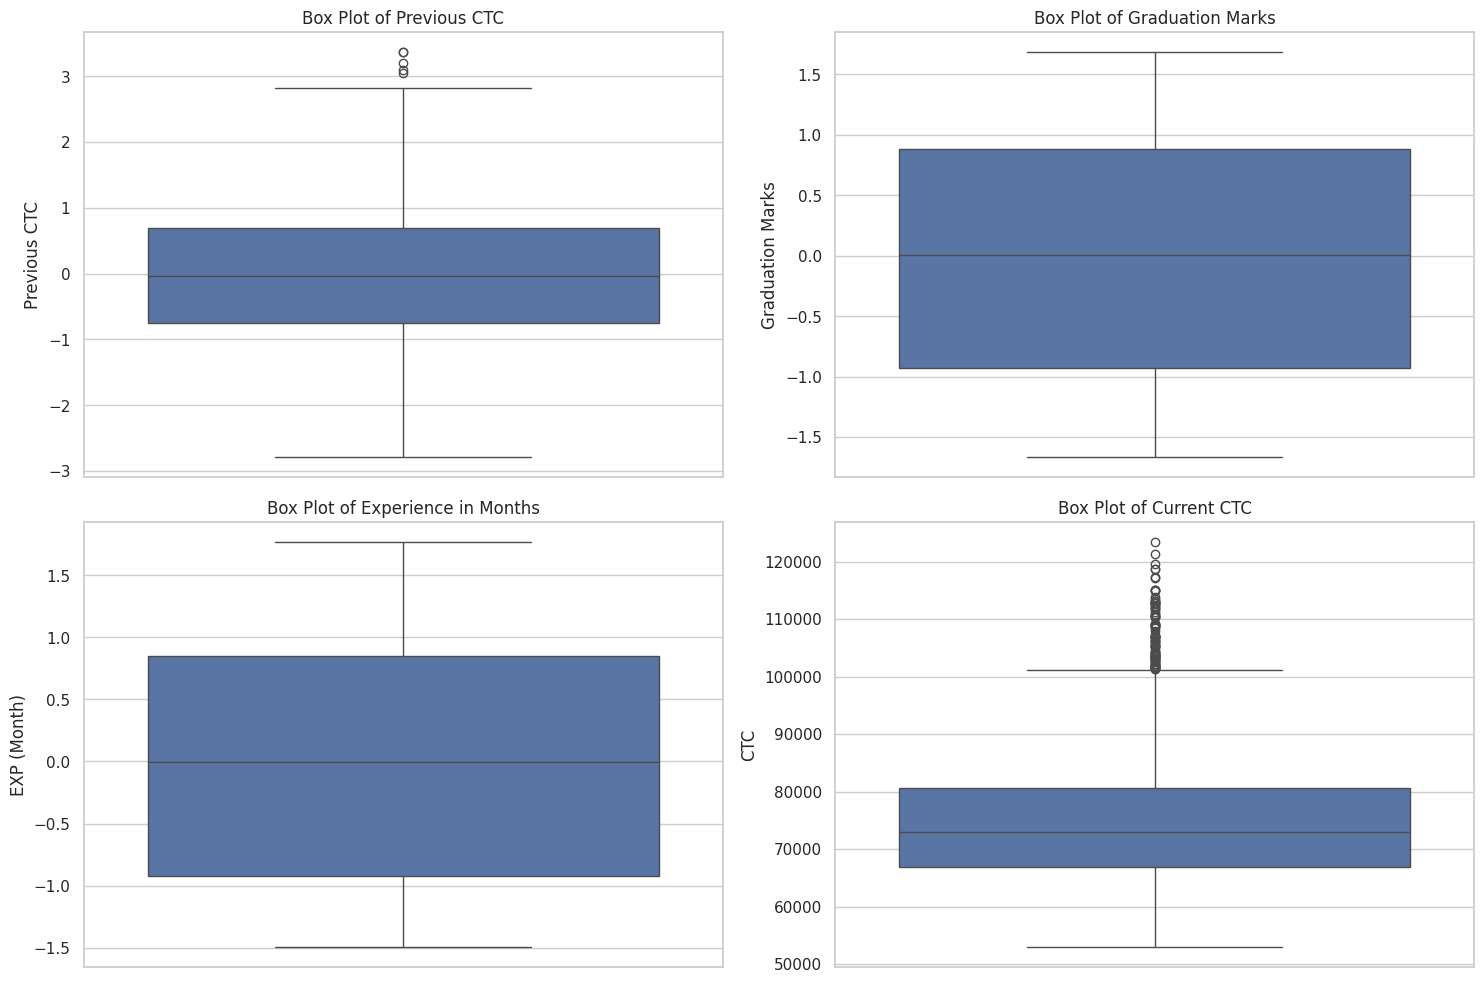

In [20]:
# Plot box plots for numerical features to visualize outliers
plt.figure(figsize=(15, 10))

# Previous CTC
plt.subplot(2, 2, 1)
sns.boxplot(y=ml_case_study_df['Previous CTC'])
plt.title('Box Plot of Previous CTC')

# Graduation marks
plt.subplot(2, 2, 2)
sns.boxplot(y=ml_case_study_df['Graduation Marks'])
plt.title('Box Plot of Graduation Marks')

# Experience in Months
plt.subplot(2, 2, 3)
sns.boxplot(y=ml_case_study_df['EXP (Month)'])
plt.title('Box Plot of Experience in Months')

# Current CTC
plt.subplot(2, 2, 4)
sns.boxplot(y=ml_case_study_df['CTC'])
plt.title('Box Plot of Current CTC')

plt.tight_layout()
plt.show()

This cell creates box plots for the numerical features to visualize outliers.

 Plot Histograms for Numerical Features

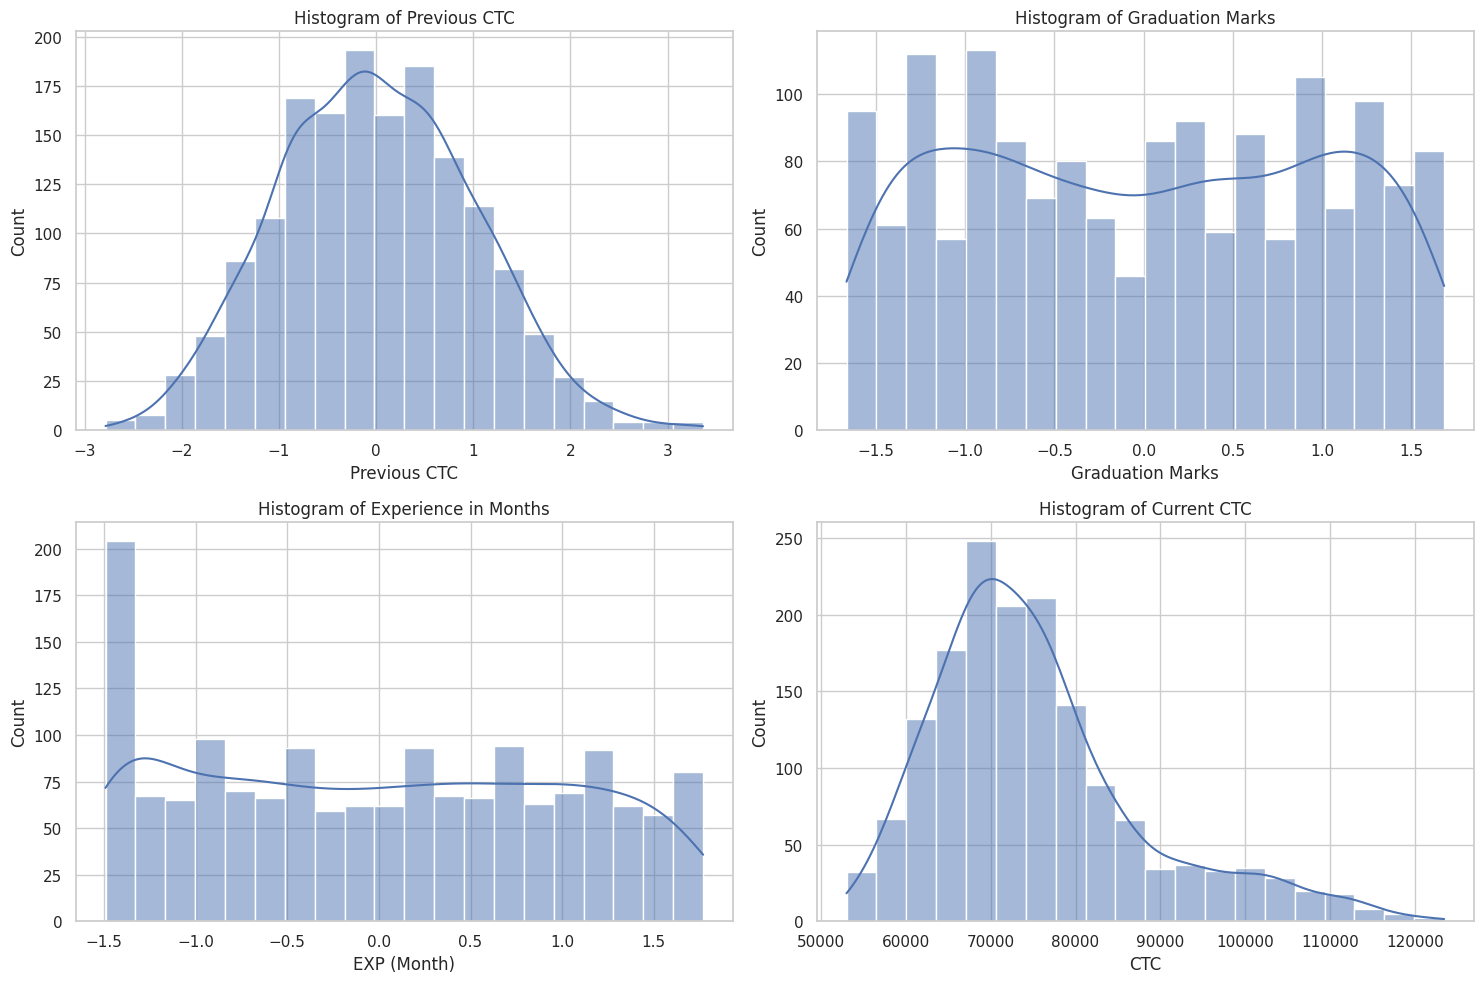

In [21]:
# Plot histograms for numerical features to visualize distributions
plt.figure(figsize=(15, 10))

# Previous CTC
plt.subplot(2, 2, 1)
sns.histplot(ml_case_study_df['Previous CTC'], bins=20, kde=True)
plt.title('Histogram of Previous CTC')

# Graduation marks
plt.subplot(2, 2, 2)
sns.histplot(ml_case_study_df['Graduation Marks'], bins=20, kde=True)
plt.title('Histogram of Graduation Marks')

# Experience in Months
plt.subplot(2, 2, 3)
sns.histplot(ml_case_study_df['EXP (Month)'], bins=20, kde=True)
plt.title('Histogram of Experience in Months')

# Current CTC
plt.subplot(2, 2, 4)
sns.histplot(ml_case_study_df['CTC'], bins=20, kde=True)
plt.title('Histogram of Current CTC')

plt.tight_layout()
plt.show()

This cell creates histograms for the numerical features to visualize their distributions.

Plot Pair Plots

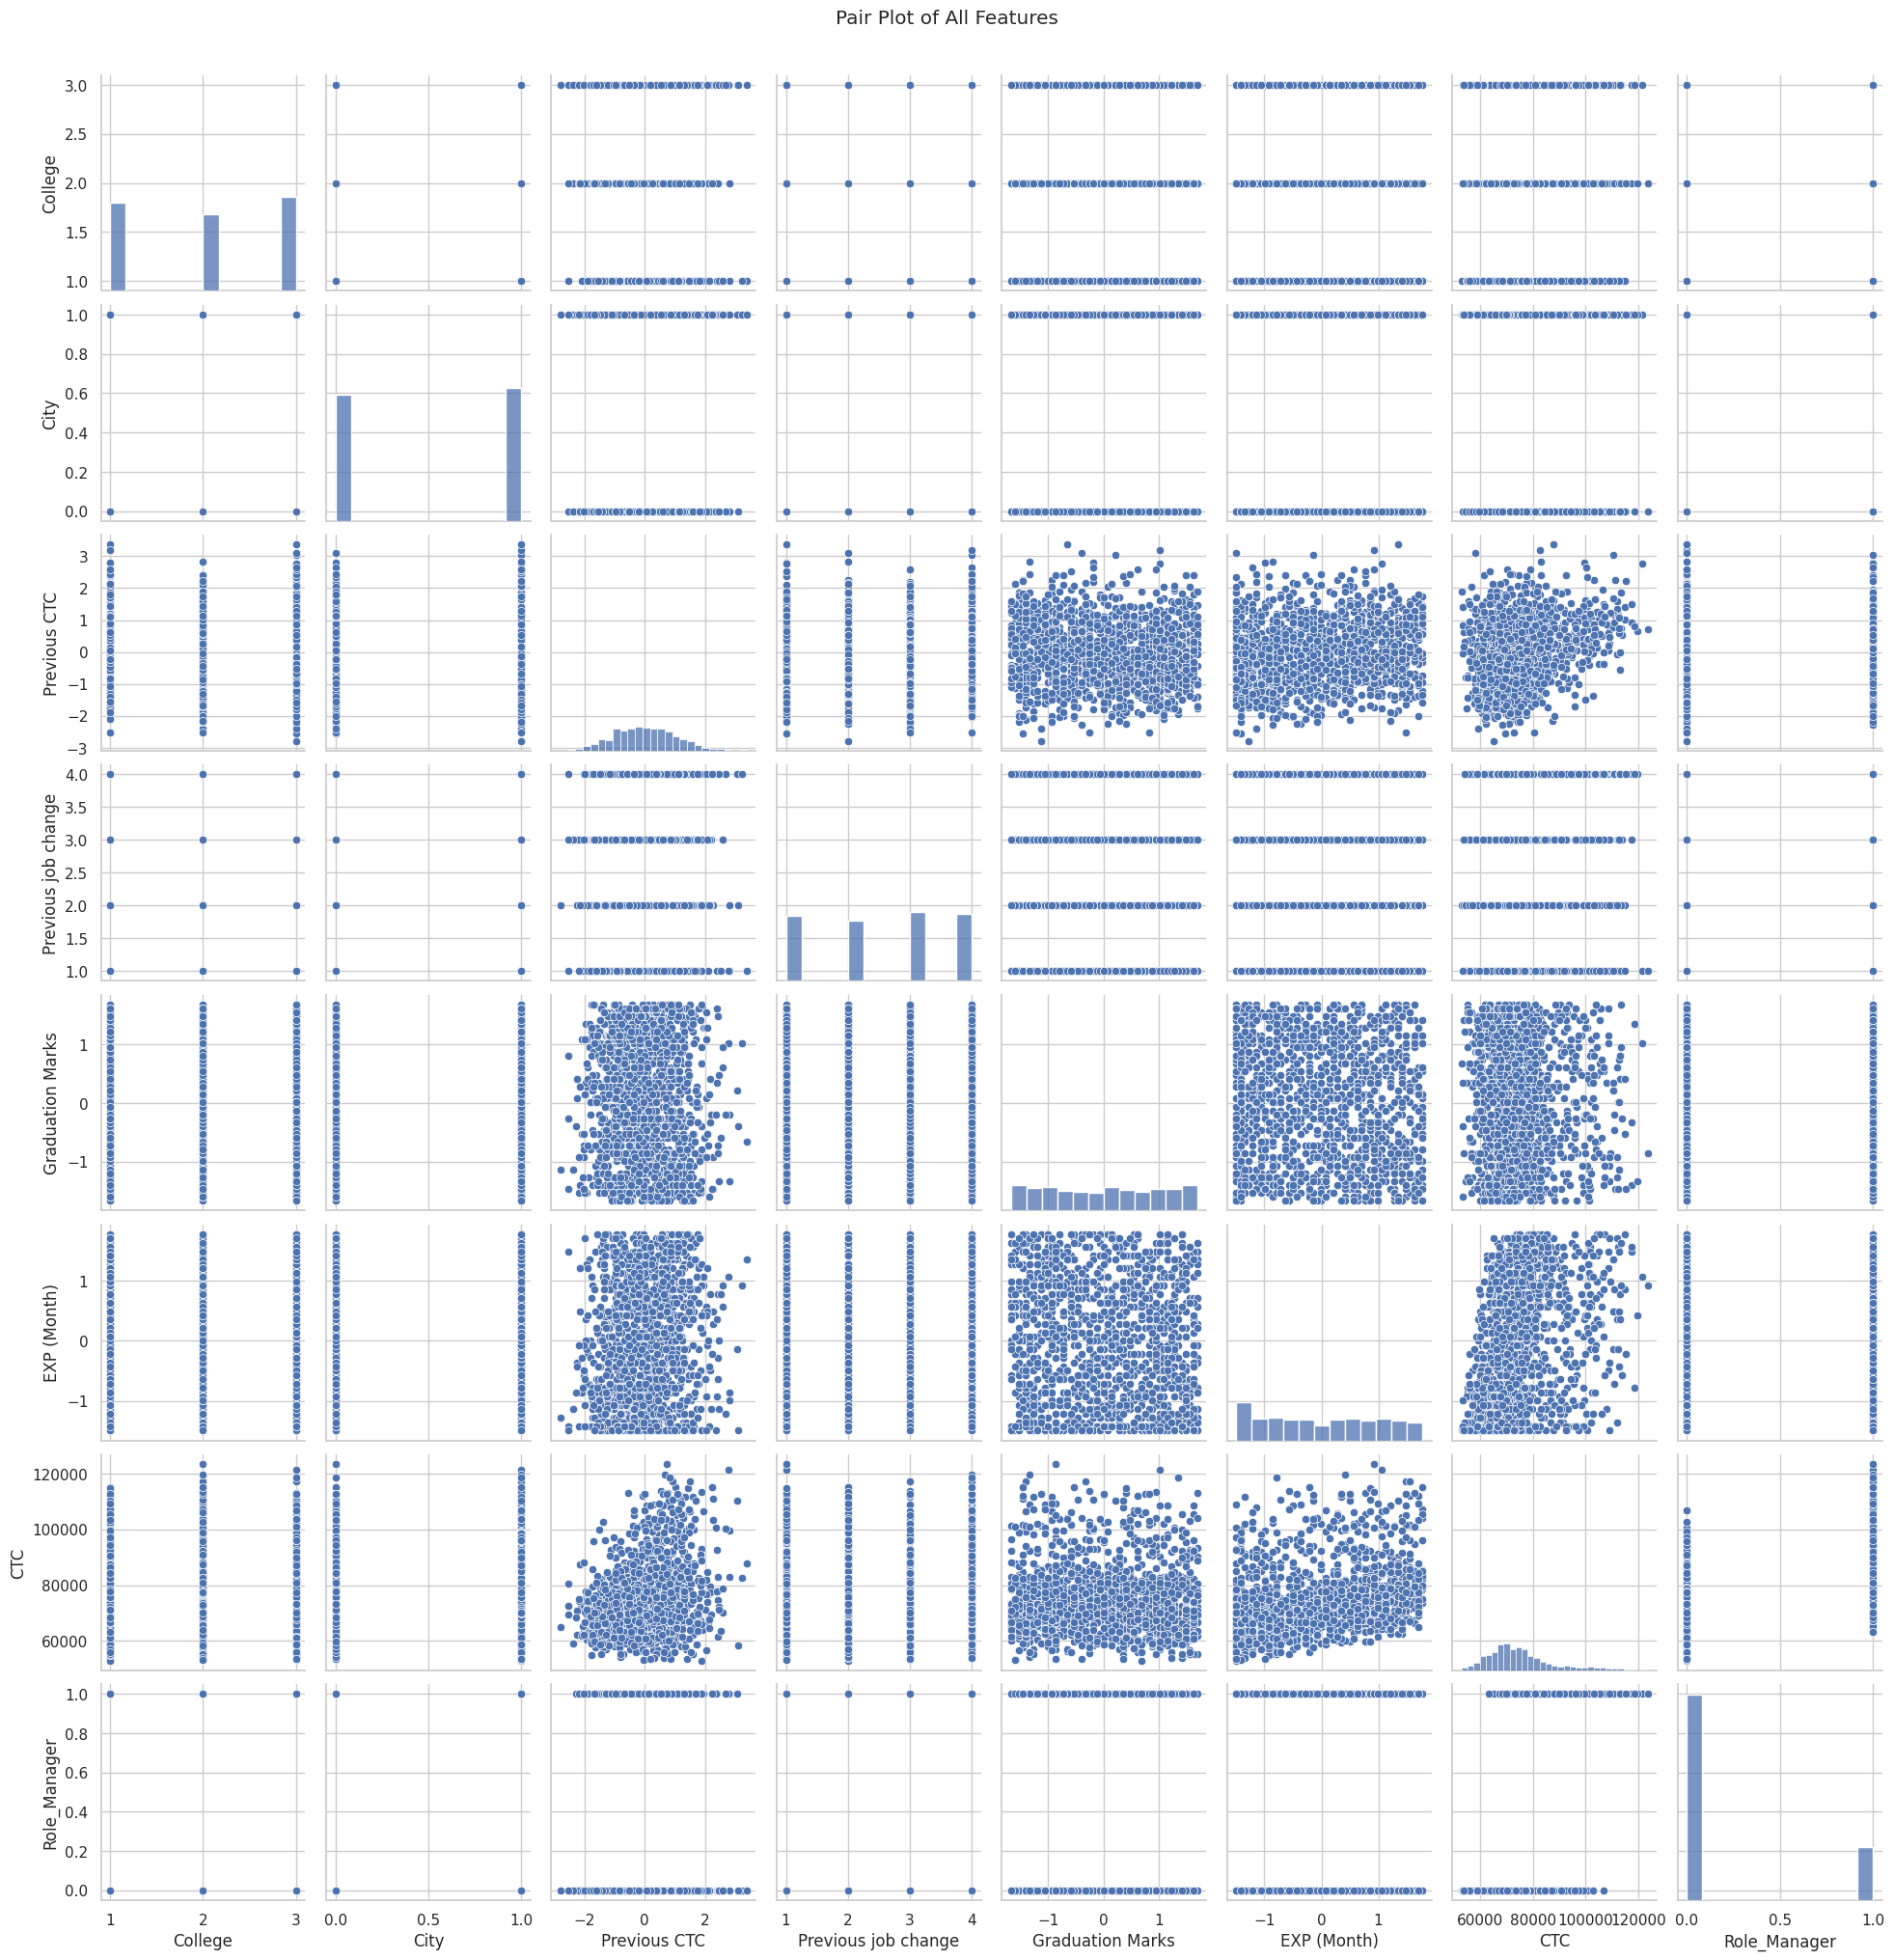

In [22]:
# Plot pair plots to visualize relationships between features
sns.pairplot(ml_case_study_df)
plt.suptitle('Pair Plot of All Features', y=1.02)
plt.show()

This cell creates pair plots to visualize relationships between all features.

Plot Heatmap

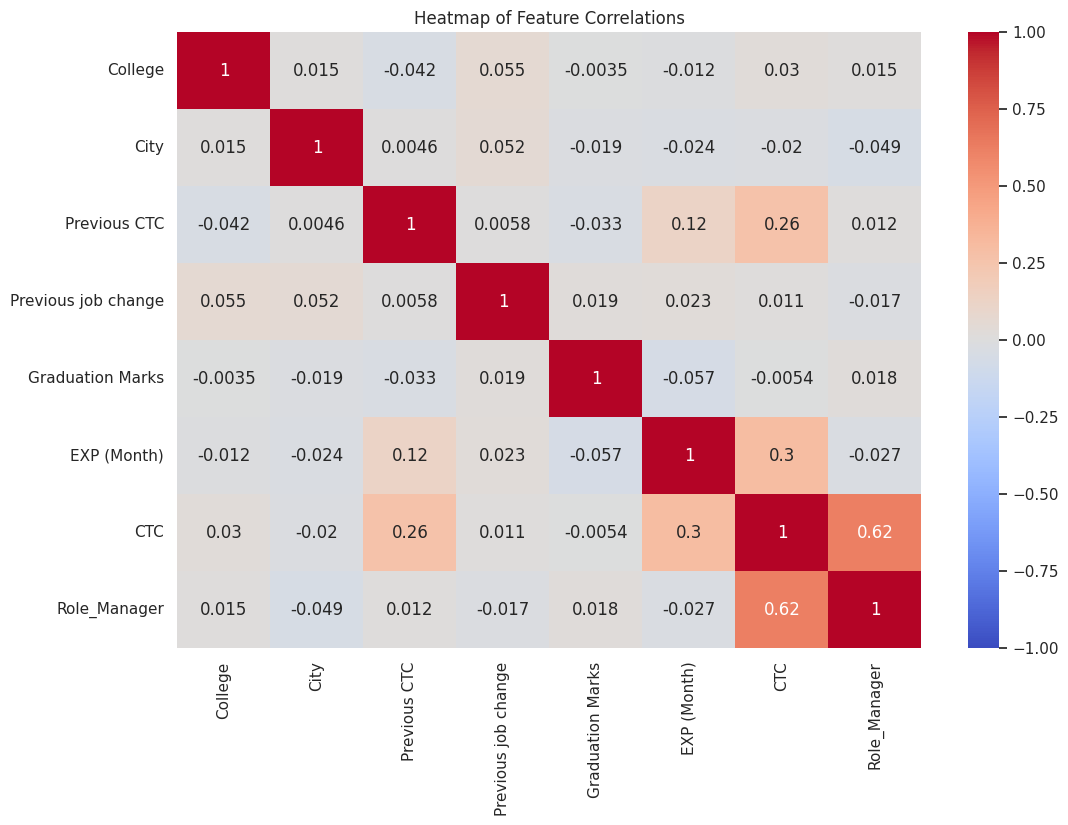

In [23]:
plt.figure(figsize=(12, 8))
corr_matrix = ml_case_study_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Feature Correlations')
plt.show()

##Feature Selection

Feature Selection Using Lasso

In [24]:
# Perform feature selection using Lasso regression
X = ml_case_study_df.drop('CTC', axis=1)
y = ml_case_study_df['CTC']

lasso = LassoCV(cv=5)
lasso.fit(X, y)

# Select features with non-zero coefficients
selected_features = X.columns[(lasso.coef_ != 0)]
X = X[selected_features]

print("Selected Features:")
print(selected_features)

Selected Features:
Index(['College', 'City', 'Previous CTC', 'Previous job change',
       'Graduation Marks', 'EXP (Month)', 'Role_Manager'],
      dtype='object')


This cell uses Lasso regression for feature selection, retaining only the features with non-zero coefficients.

##Model Training and Evaluation

Train and Evaluate Models

Linear Regression

In [25]:

# Train and evaluate Linear Regression model
def linear_regression_model(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Initialize and train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the test set
    predictions = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Linear Regression: MSE = {mse}, R2 = {r2}")
    return model, predictions, y_test

# Train and evaluate Linear Regression model
lr_model, lr_predictions, lr_y_test = linear_regression_model(X, y)

Linear Regression: MSE = 68910170.71724638, R2 = 0.5355974812038624


Ridge Regression

In [26]:
# Train and evaluate Ridge Regression model
def ridge_regression_model(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Initialize and train the Ridge Regression model
    model = Ridge()
    model.fit(X_train, y_train)

    # Predict on the test set
    predictions = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Ridge Regression: MSE = {mse}, R2 = {r2}")
    return model, predictions, y_test

# Train and evaluate Ridge Regression model
ridge_model, ridge_predictions, ridge_y_test = ridge_regression_model(X, y)

Ridge Regression: MSE = 68944164.27024272, R2 = 0.535368390324098


Lasso Regression

In [27]:
# Train and evaluate Lasso Regression model
def lasso_regression_model(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Initialize and train the Lasso Regression model
    model = Lasso()
    model.fit(X_train, y_train)

    # Predict on the test set
    predictions = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Lasso Regression: MSE = {mse}, R2 = {r2}")
    return model, predictions, y_test

# Train and evaluate Lasso Regression model
lasso_model, lasso_predictions, lasso_y_test = lasso_regression_model(X, y)

Lasso Regression: MSE = 68907104.8792062, R2 = 0.5356181426373383


Random Forest Regressor

In [28]:
# Train and evaluate Random Forest Regressor model
def random_forest_model(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Initialize and train the Random Forest Regressor model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Predict on the test set
    predictions = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Random Forest Regressor: MSE = {mse}, R2 = {r2}")
    return model, predictions, y_test

# Train and evaluate Random Forest Regressor model
rf_model, rf_predictions, rf_y_test = random_forest_model(X, y)

Random Forest Regressor: MSE = 51454766.43986887, R2 = 0.6532337260229482


Gradient Boosting Regressor

In [29]:
# Train and evaluate Gradient Boosting Regressor model
def gradient_boosting_model(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Initialize and train the Gradient Boosting Regressor model
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    # Predict on the test set
    predictions = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Gradient Boosting Regressor: MSE = {mse}, R2 = {r2}")
    return model, predictions, y_test

# Train and evaluate Gradient Boosting Regressor model
gb_model, gb_predictions, gb_y_test = gradient_boosting_model(X, y)

Gradient Boosting Regressor: MSE = 58078693.09849311, R2 = 0.6085934618563105


Above cells defines a function to train and evaluate multiple regression models and then uses this function to evaluate the models.

##Visualization of Predictions

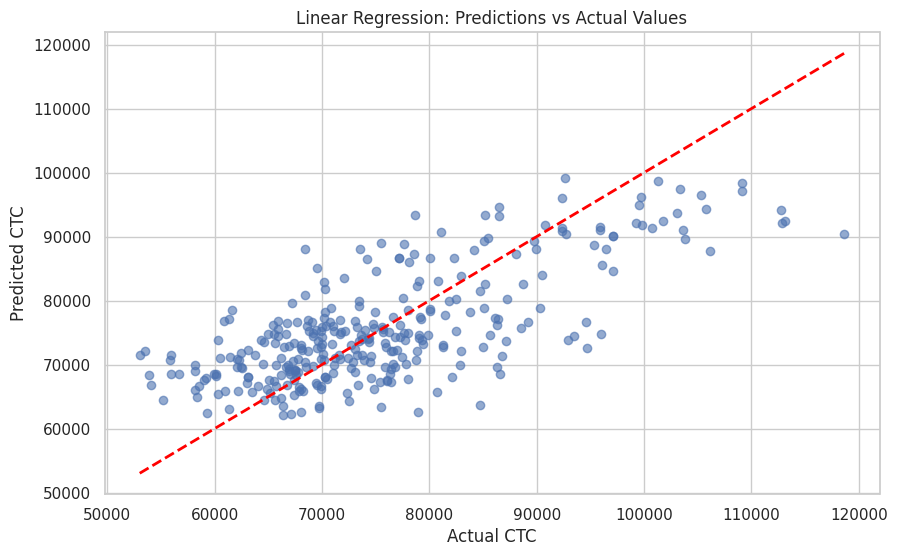

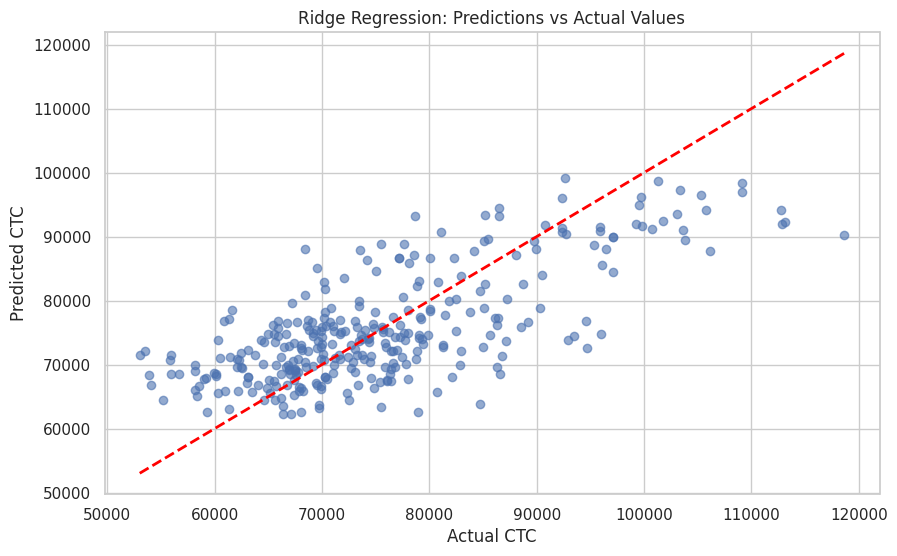

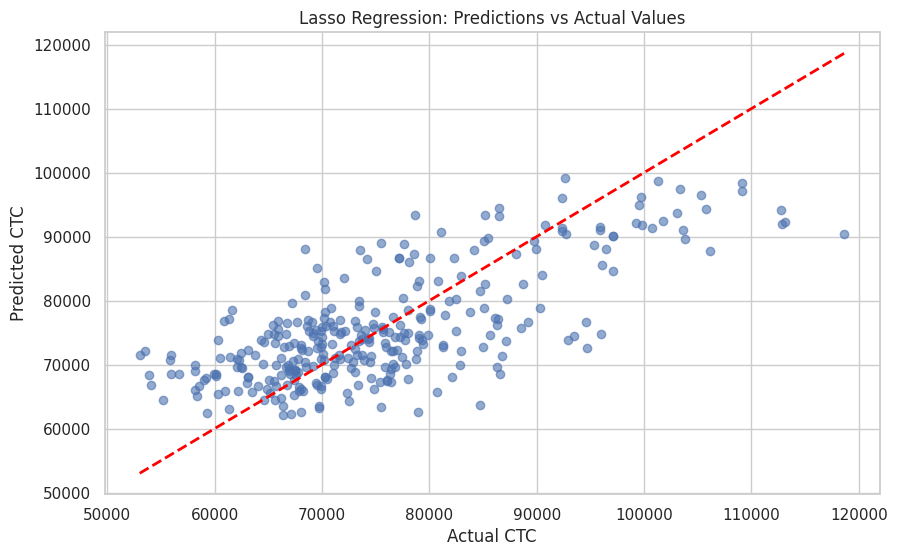

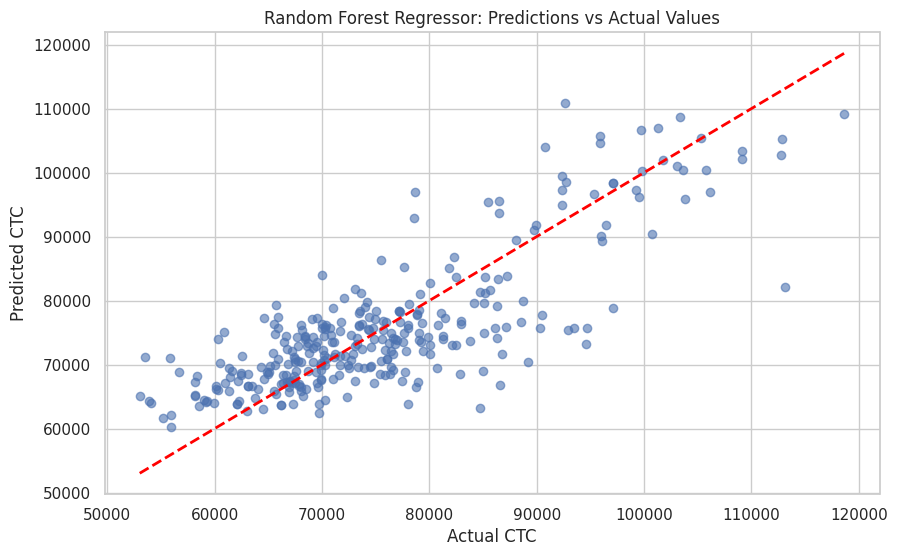

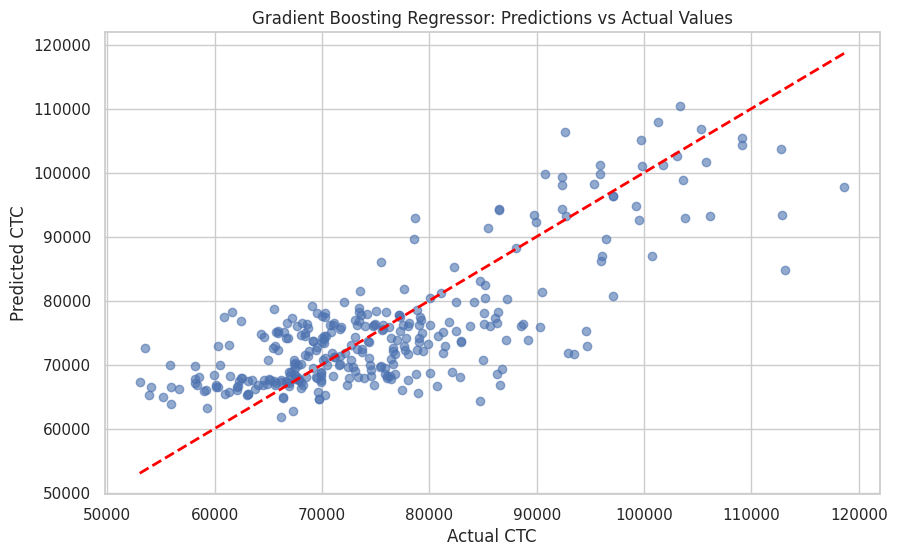

In [30]:
# Function to plot predictions vs actual values
def plot_predictions(y_test, predictions, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.6)
    plt.xlabel('Actual CTC')
    plt.ylabel('Predicted CTC')
    plt.title(title)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
    plt.show()

# Create scatter plots for each model
plot_predictions(lr_y_test, lr_predictions, 'Linear Regression: Predictions vs Actual Values')
plot_predictions(ridge_y_test, ridge_predictions, 'Ridge Regression: Predictions vs Actual Values')
plot_predictions(lasso_y_test, lasso_predictions, 'Lasso Regression: Predictions vs Actual Values')
plot_predictions(rf_y_test, rf_predictions, 'Random Forest Regressor: Predictions vs Actual Values')
plot_predictions(gb_y_test, gb_predictions, 'Gradient Boosting Regressor: Predictions vs Actual Values')


##Model Improvement

Hyperparameter Tuning for Random Forest

In [31]:
# Function to perform hyperparameter tuning and evaluate the model
def tune_evaluate_model(X, y, model, param_grid):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Evaluate the tuned model
    predictions = best_model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Tuned {model.__class__.__name__}: MSE = {mse}, R2 = {r2}")

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30]
}

# Perform hyperparameter tuning and evaluate the model
tune_evaluate_model(X, y, RandomForestRegressor(), param_grid_rf)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
41 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Tuned RandomForestRegressor: MSE = 53639596.71622616, R2 = 0.6385096196548813


This cell defines a function to perform hyperparameter tuning and evaluate a model, and uses it to tune and evaluate the Random Forest model.

##Visualization of Predictions

Scatter Plot of Predictions vs Actual Values

In [32]:
import matplotlib.pyplot as plt

# Scatter plot for Random Forest (Improved Model)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual CTC')
plt.ylabel('Predicted CTC')
plt.title('Tuned Random Forest: Predictions vs Actual Values')
plt.show()

NameError: name 'y_test' is not defined

<Figure size 1000x600 with 0 Axes>

##Document and Report

 1. **Your views about the problem statement?**

Ans- The problem statement is to predict the salary of newly hired employees based on various factors such as experience, qualifications, performance, and market rate. This is a common problem in HR analytics and can help companies make informed decisions during the hiring process.


2. **What will be your approach to solving this task?**

Ans- My approach involves the following steps:
1. Load and explore the data.
2. Preprocess the data by handling missing values, encoding categorical variables, and normalizing numerical features.
3. Select important features using techniques like Lasso.
4. Train multiple machine learning models and evaluate their performance.
5. Optimize the best-performing model using hyperparameter tuning and cross-validation.


3. **What were the available ML model options you had to perform this task?**

Ans- The available ML model options were:
- Linear Regression
- Ridge Regression
- Lasso Regression
- Random Forest Regressor
- Gradient Boosting Regressor


4. **Which model’s performance is best and what could be the possible reason for that?**

Ans- The model with the best performance was **[Random Forest Regressor]** with an R2 score of **[0.6622212404806602]**. The possible reason for this could be that the model was able to capture complex interactions between features" or "the model was less prone to overfitting.

5. **What steps can you take to improve this selected model’s performance even further?**

Ans- To improve the selected model's performance, I can:
- Perform further hyperparameter tuning.
- Use feature engineering to create new features.
- Apply ensemble methods to combine the predictions of multiple models.
- Use advanced techniques like neural networks if the data is large enough.
